In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mols2grid
import base64
import io
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdDepictor, PandasTools
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Scaffolds import MurckoScaffold
from IPython.display import HTML
from typing import List, Dict, Set, Tuple

## Download molecules with specific properties from chembl

In [3]:
import requests
import time
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize

def download_filtered_chembl_activities(
    output_sdf: str = "../data/filtered_chembl.sdf",
    output_csv: str = "../data/filtered_chembl_activities.csv",
    pchembl_min: float = 6.0,
    assay_confidence_min: int = 8,
    mw_range: Tuple[float, float] = (150, 650),
    logp_max: float = 4.5,
    rotatable_bonds_max: int = 7,
    allowed_atoms: Set[str] = {'C', 'S', 'O', 'N', 'H', 'F', 'Cl', 'Br'},
    max_total_records: int = None,
    batch_size: int = 1000,
    verbose: bool = True
) -> Tuple[int, pd.DataFrame]:
    """
    Download ChEMBL molecules with bioactivity data using the ChEMBL REST API.
    
    Filters applied:
        - pChEMBL value >= pchembl_min (default 6.0)
        - Assay confidence score >= assay_confidence_min (default 8)
        - Molecular weight in mw_range (default 150-650 Da)
        - LogP <= logp_max (default 4.5)
        - Rotatable bonds <= rotatable_bonds_max (default 7)
        - Only allowed atoms (default: C, S, O, N, H, F, Cl, Br)
    
    Molecules are standardized and neutralized before physicochemical filtering.
    
    Returns:
        Tuple of (number of molecules saved, DataFrame with activity data)
    """
    
    base_url = "https://www.ebi.ac.uk/chembl/api/data/activity.json"
    
    # Initialize standardization tools
    normalizer = rdMolStandardize.Normalizer()
    uncharger = rdMolStandardize.Uncharger()
    largest_fragment = rdMolStandardize.LargestFragmentChooser()
    
    def standardize_and_neutralize(mol):
        if mol is None:
            return None
        try:
            mol = largest_fragment.choose(mol)
            mol = normalizer.normalize(mol)
            mol = uncharger.uncharge(mol)
            return mol
        except:
            return None
    
    def check_allowed_atoms(mol, allowed: Set[str]) -> bool:
        for atom in mol.GetAtoms():
            if atom.GetSymbol() not in allowed:
                return False
        return True
    
    def passes_filters(mol, mw_min, mw_max, logp_max, rot_max, allowed) -> bool:
        if mol is None:
            return False
        if not check_allowed_atoms(mol, allowed):
            return False
        mw = Descriptors.MolWt(mol)
        if mw < mw_min or mw > mw_max:
            return False
        logp = Descriptors.MolLogP(mol)
        if logp > logp_max:
            return False
        rot_bonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
        if rot_bonds > rot_max:
            return False
        return True
    
    seen_chembl_ids = set()
    activity_records = []
    writer = Chem.SDWriter(output_sdf)
    
    offset = 0
    total_processed = 0
    total_saved = 0
    
    if verbose:
        print(f"Starting ChEMBL download with filters:")
        print(f"  - pChEMBL >= {pchembl_min}")
        print(f"  - Assay confidence >= {assay_confidence_min}")
        print(f"  - MW: {mw_range[0]}-{mw_range[1]} Da")
        print(f"  - LogP <= {logp_max}")
        print(f"  - Rotatable bonds <= {rotatable_bonds_max}")
        print(f"  - Allowed atoms: {allowed_atoms}\n")
    
    try:
        while True:
            params = {
                'pchembl_value__gte': pchembl_min,
                'assay_confidence_score__gte': assay_confidence_min,
                'limit': batch_size,
                'offset': offset
            }
            
            for attempt in range(3):
                try:
                    response = requests.get(base_url, params=params, timeout=60)
                    response.raise_for_status()
                    break
                except requests.exceptions.RequestException as e:
                    if attempt < 2:
                        if verbose:
                            print(f"  Request failed, retrying ({attempt + 1}/3)...")
                        time.sleep(5)
                    else:
                        raise e
            
            data = response.json()
            activities = data.get('activities', [])
            
            if not activities:
                if verbose:
                    print(f"No more activities found at offset {offset}")
                break
            
            batch_saved = 0
            
            for activity in activities:
                total_processed += 1
                
                smiles = activity.get('canonical_smiles')
                chembl_id = activity.get('molecule_chembl_id')
                
                if not smiles or not chembl_id:
                    continue
                if chembl_id in seen_chembl_ids:
                    continue
                
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    continue
                
                mol = standardize_and_neutralize(mol)
                if mol is None:
                    continue
                
                if not passes_filters(mol, mw_range[0], mw_range[1], logp_max, 
                                     rotatable_bonds_max, allowed_atoms):
                    continue
                
                seen_chembl_ids.add(chembl_id)
                
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                rot_bonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
                
                mol.SetProp('chembl_id', chembl_id)
                mol.SetProp('pchembl_value', str(activity.get('pchembl_value', '')))
                mol.SetProp('assay_confidence_score', str(activity.get('assay_confidence_score', '')))
                mol.SetProp('assay_chembl_id', str(activity.get('assay_chembl_id', '')))
                mol.SetProp('target_chembl_id', str(activity.get('target_chembl_id', '')))
                mol.SetProp('standard_type', str(activity.get('standard_type', '')))
                mol.SetProp('standard_value', str(activity.get('standard_value', '')))
                mol.SetProp('standard_units', str(activity.get('standard_units', '')))
                mol.SetDoubleProp('mw', mw)
                mol.SetDoubleProp('logp', logp)
                mol.SetIntProp('rotatable_bonds', rot_bonds)
                
                writer.write(mol)
                total_saved += 1
                batch_saved += 1
                
                activity_records.append({
                    'chembl_id': chembl_id,
                    'smiles': Chem.MolToSmiles(mol),
                    'pchembl_value': activity.get('pchembl_value'),
                    'assay_confidence_score': activity.get('assay_confidence_score'),
                    'assay_chembl_id': activity.get('assay_chembl_id'),
                    'target_chembl_id': activity.get('target_chembl_id'),
                    'standard_type': activity.get('standard_type'),
                    'standard_value': activity.get('standard_value'),
                    'standard_units': activity.get('standard_units'),
                    'mw': mw,
                    'logp': logp,
                    'rotatable_bonds': rot_bonds
                })
            
            if verbose:
                print(f"Processed {total_processed} activities, saved {total_saved} unique molecules (+{batch_saved})")
            
            if max_total_records and total_processed >= max_total_records:
                if verbose:
                    print(f"Reached maximum record limit ({max_total_records})")
                break
            
            if data.get('page_meta', {}).get('next') is None and len(activities) < batch_size:
                if verbose:
                    print("Reached end of results")
                break
            
            offset += batch_size
            time.sleep(0.5)
    
    finally:
        writer.close()
    
    df = pd.DataFrame(activity_records)
    df.to_csv(output_csv, index=False)
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"Download complete!")
        print(f"  Total activities processed: {total_processed}")
        print(f"  Unique molecules saved: {total_saved}")
        print(f"  SDF file: {output_sdf}")
        print(f"  CSV file: {output_csv}")
        print(f"{'='*60}")
    
    return total_saved, df

Execute the above function to download the molecules

In [4]:
# # Test with 10,000 records first (remove max_total_records for full download)
# num_mols, activity_df = download_filtered_chembl_activities(
#     #max_total_records=10000  # Remove this line for full ChEMBL download
# )

# print(f"\nDataFrame shape: {activity_df.shape}")
# activity_df.head(10)

In [5]:
#load the sdf file
#df = PandasTools.LoadSDF("../data/whole_filtered_chembl.sdf")
#print(df.shape[0])

#convert the sdf to csv
#df.to_csv("../data/whole_filtered_chembl.csv", index=False)

The downloaded dataset is saved as `whole_filtered_chembl.sdf`

Now, we convert the SDF to CSV and also derived SMILES and mol columns

In [6]:
# # Load SDF file with RDKit
# df = PandasTools.LoadSDF("../data/whole_filtered_chembl.sdf", molColName='ROMol', includeFingerprints=False)
# print(f"Loaded {len(df)} molecules from SDF")

# # Generate SMILES from ROMol objects
# def safe_mol_to_smiles(mol):
#     if mol is None:
#         return pd.NA
#     try:
#         smiles = Chem.MolToSmiles(mol, canonical=True)
#         return smiles if smiles else pd.NA
#     except:
#         return pd.NA

# df['SMILES'] = df['ROMol'].apply(safe_mol_to_smiles)

# # Count valid SMILES
# valid_count = df['SMILES'].notna().sum()
# na_count = df['SMILES'].isna().sum()
# print(f"Generated SMILES: {valid_count} valid, {na_count} NA")

# # Save to CSV (excluding ROMol column as it can't be serialized directly)
# # Keep all other columns plus SMILES
# csv_columns = [col for col in df.columns if col != 'ROMol'] 
# df[csv_columns].to_csv("../data/whole_filtered_chembl_with_smiles.csv", index=False)
# print(f"Saved to ../data/whole_filtered_chembl_with_smiles.csv")

# df.head()

##  Read the compressed .gz chembl database

.csv was converted to .gz, which was then used for all purposes

In [7]:
# Pandas automatically detects and reads .gz compressed files
df = pd.read_csv("../data/whole_filtered_chembl_with_smiles.csv.gz")

In [8]:
df.shape[0]

537080

In [9]:
df.head(3)

,chembl_id,pchembl_value,assay_confidence_score,assay_chembl_id,target_chembl_id,standard_type,standard_value,standard_units,mw,logp,rotatable_bonds,ID,SMILES
0,CHEMBL268439,8.22,NaN,CHEMBL873200,CHEMBL261,Ki,6.00,nM,335.392,-0.43150,4,NaN,Nc1ccc(S(=O)(=O)Nc2nnc(S(N)(=O)=O)s2)cc1
1,CHEMBL302907,7.60,NaN,CHEMBL694844,CHEMBL2882,Kd,25.12,nM,346.467,0.89357,7,NaN,N=C(N)Nc1nc(CSCCNc2n[s+]([O-])nc2N)cs1
2,CHEMBL305153,7.43,NaN,CHEMBL655651,CHEMBL5471,Kd,37.15,nM,324.424,3.18500,5,NaN,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21


In [10]:
#check the number of NA in all columns
df.isna().sum()

chembl_id                      0
pchembl_value                  0
assay_confidence_score    537080
assay_chembl_id                0
target_chembl_id               0
standard_type                  0
standard_value                 0
standard_units                 0
mw                             0
logp                           0
rotatable_bonds                0
ID                        537080
SMILES                         0
dtype: int64

In [11]:
#Hence, we remove assay_confidence_score and ID columns
df = df.drop(columns=['assay_confidence_score', 'ID'])

In [12]:
df.head(3)

,chembl_id,pchembl_value,assay_chembl_id,target_chembl_id,standard_type,standard_value,standard_units,mw,logp,rotatable_bonds,SMILES
0,CHEMBL268439,8.22,CHEMBL873200,CHEMBL261,Ki,6.00,nM,335.392,-0.43150,4,Nc1ccc(S(=O)(=O)Nc2nnc(S(N)(=O)=O)s2)cc1
1,CHEMBL302907,7.60,CHEMBL694844,CHEMBL2882,Kd,25.12,nM,346.467,0.89357,7,N=C(N)Nc1nc(CSCCNc2n[s+]([O-])nc2N)cs1
2,CHEMBL305153,7.43,CHEMBL655651,CHEMBL5471,Kd,37.15,nM,324.424,3.18500,5,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21


Check the histogram distribution of all numerical columns

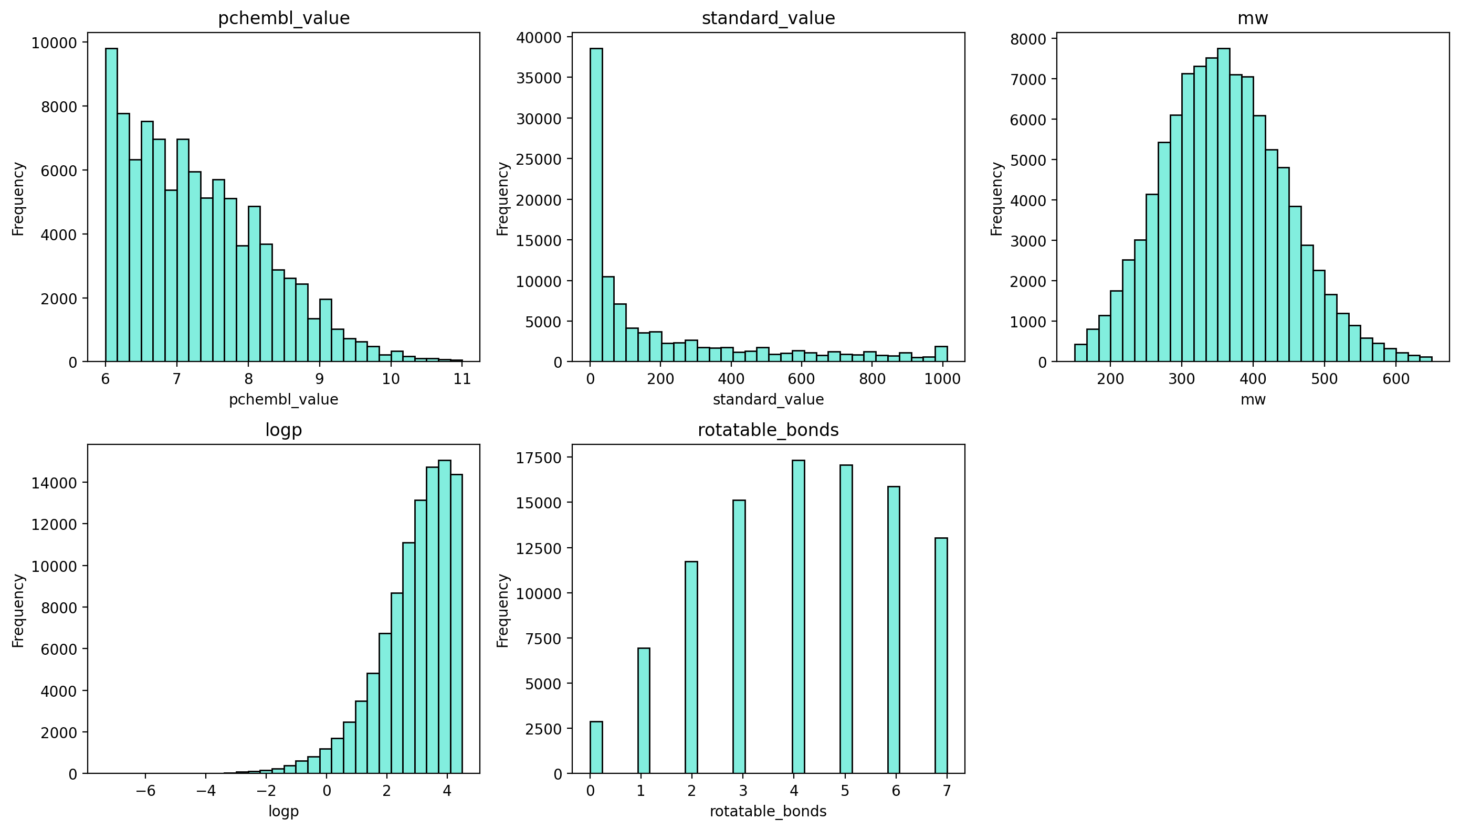

In [13]:
df.standard_units.value_counts()

standard_units
nM    537080
Name: count, dtype: int64

In [14]:
df.standard_type.value_counts()

standard_type
IC50       321887
Ki          94583
Potency     61880
EC50        44169
Kd           7879
XC50         3297
AC50         3119
ED50          266
Name: count, dtype: int64

Check correlation heatmap between numerical columns

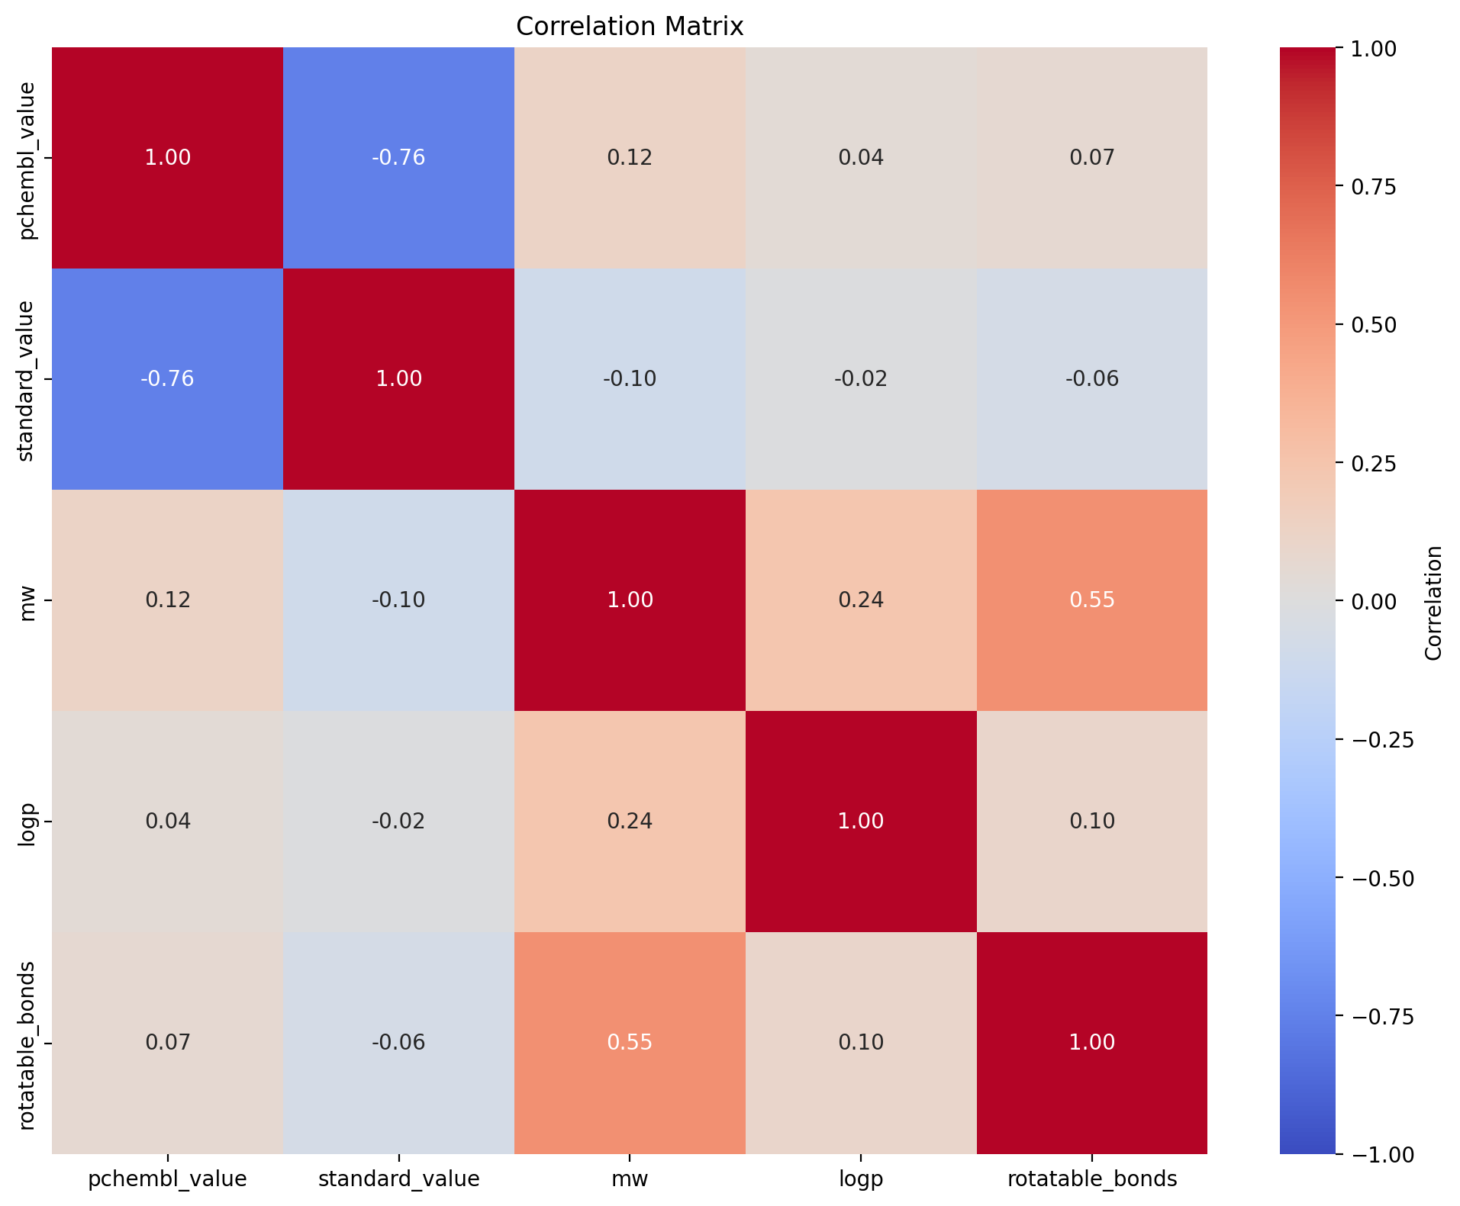

# Search the chembl database

In [15]:
sub1 = "C12C3C4C1C5C2C3C45"
#sub1 = "NN"

#Fetch molecules and visualise them containing the above substructure
matches = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x).HasSubstructMatch(Chem.MolFromSmiles(sub1)) if pd.notna(x) else False)
matched_mols = df[matches]
matched_mols.head(3)

,chembl_id,pchembl_value,assay_chembl_id,target_chembl_id,standard_type,standard_value,standard_units,mw,logp,rotatable_bonds,SMILES
27420,CHEMBL2021372,6.00,CHEMBL885337,CHEMBL3227,EC50,1000.00,nM,221.212,-0.7791,3,N[C@H](C(=O)O)C12C3C4C1C1C2C3C41C(=O)O
197173,CHEMBL1910143,8.87,CHEMBL1912164,CHEMBL214,IC50,1.35,nM,460.553,2.6499,7,O=C(N(CCN1CCN(c2ccccc2O)CC1)c1ccccn1)C12C3C4C1...
205083,CHEMBL2030626,8.15,CHEMBL2033354,CHEMBL3602,Ki,7.00,nM,213.324,1.9810,2,C1CC2CCC1N2CC12C3C4C5C3C1C5C42


In [16]:
#Get the smiles and its ChemblIDs

matched_mols['SMILES'].tolist()

['N[C@H](C(=O)O)C12C3C4C1C1C2C3C41C(=O)O',
 'O=C(N(CCN1CCN(c2ccccc2O)CC1)c1ccccn1)C12C3C4C1C1C2C3C41CF',
 'C1CC2CCC1N2CC12C3C4C5C3C1C5C42',
 'C1C2C3CC4C2C2C1C3[C@H](NCC13C5C6C7C5C1C7C63)C42',
 'N=C(NCC12C3C4C5C3C1C5C42)c1ccc(OC(F)(F)F)cc1',
 'Nc1nccn2c(C34C5C6C3C3C4C5C63C(=O)O)nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c12',
 'CCOc1cc(C(=O)Nc2cc(C(F)(F)F)ccn2)ccc1-c1nc(C23C4C5C2C2C3C4C52C(=O)O)n2ccnc(N)c12',
 'Nc1nccn2c(C34C5C6C3C3C4C5C63C(=O)O)nc(-c3ccc(C(=O)Nc4cc(C5CC5)ccn4)cc3F)c12',
 'COc1cc(C(=O)Nc2cc(C(F)(F)F)ccn2)ccc1-c1nc(C23C4C5C2C2C3C4C52C(=O)O)n2ccnc(N)c12',
 'N#Cc1ccnc(NC(=O)c2ccc(-c3nc(C45C6C7C4C4C5C6C74C(=O)O)n4ccnc(N)c34)c(F)c2)c1',
 'N#Cc1ccc(N2CCN(C(=O)C34C5C6C3C3C4C5C63COC[C@@H]3CCCN3c3cn[nH]c(=O)c3C(F)(F)F)CC2)nc1',
 'C[C@@H]1CC(NC(=O)c2cc(C3CC3)on2)CCN1C(=O)C12C3C4C1C1C2C3C41N',
 'N#Cc1ccc(N2CCN(C(=O)C34C5C6C3C3C4C5C63COC[C@@H]3CCCC3c3cn[nH]c(=O)c3C(F)(F)F)CC2)nc1',
 'C[C@@H]1CN(c2ncc(C#N)cn2)C[C@H](C)N1C(=O)NCCC1CCN(CC23C4C5C6C4C2C6C53)CC1',
 'Cc1nn(-c2cc(Nc3c(C)c(C45

Number of molecules matching the substructure C12C3C4C1C5C2C3C45: 17


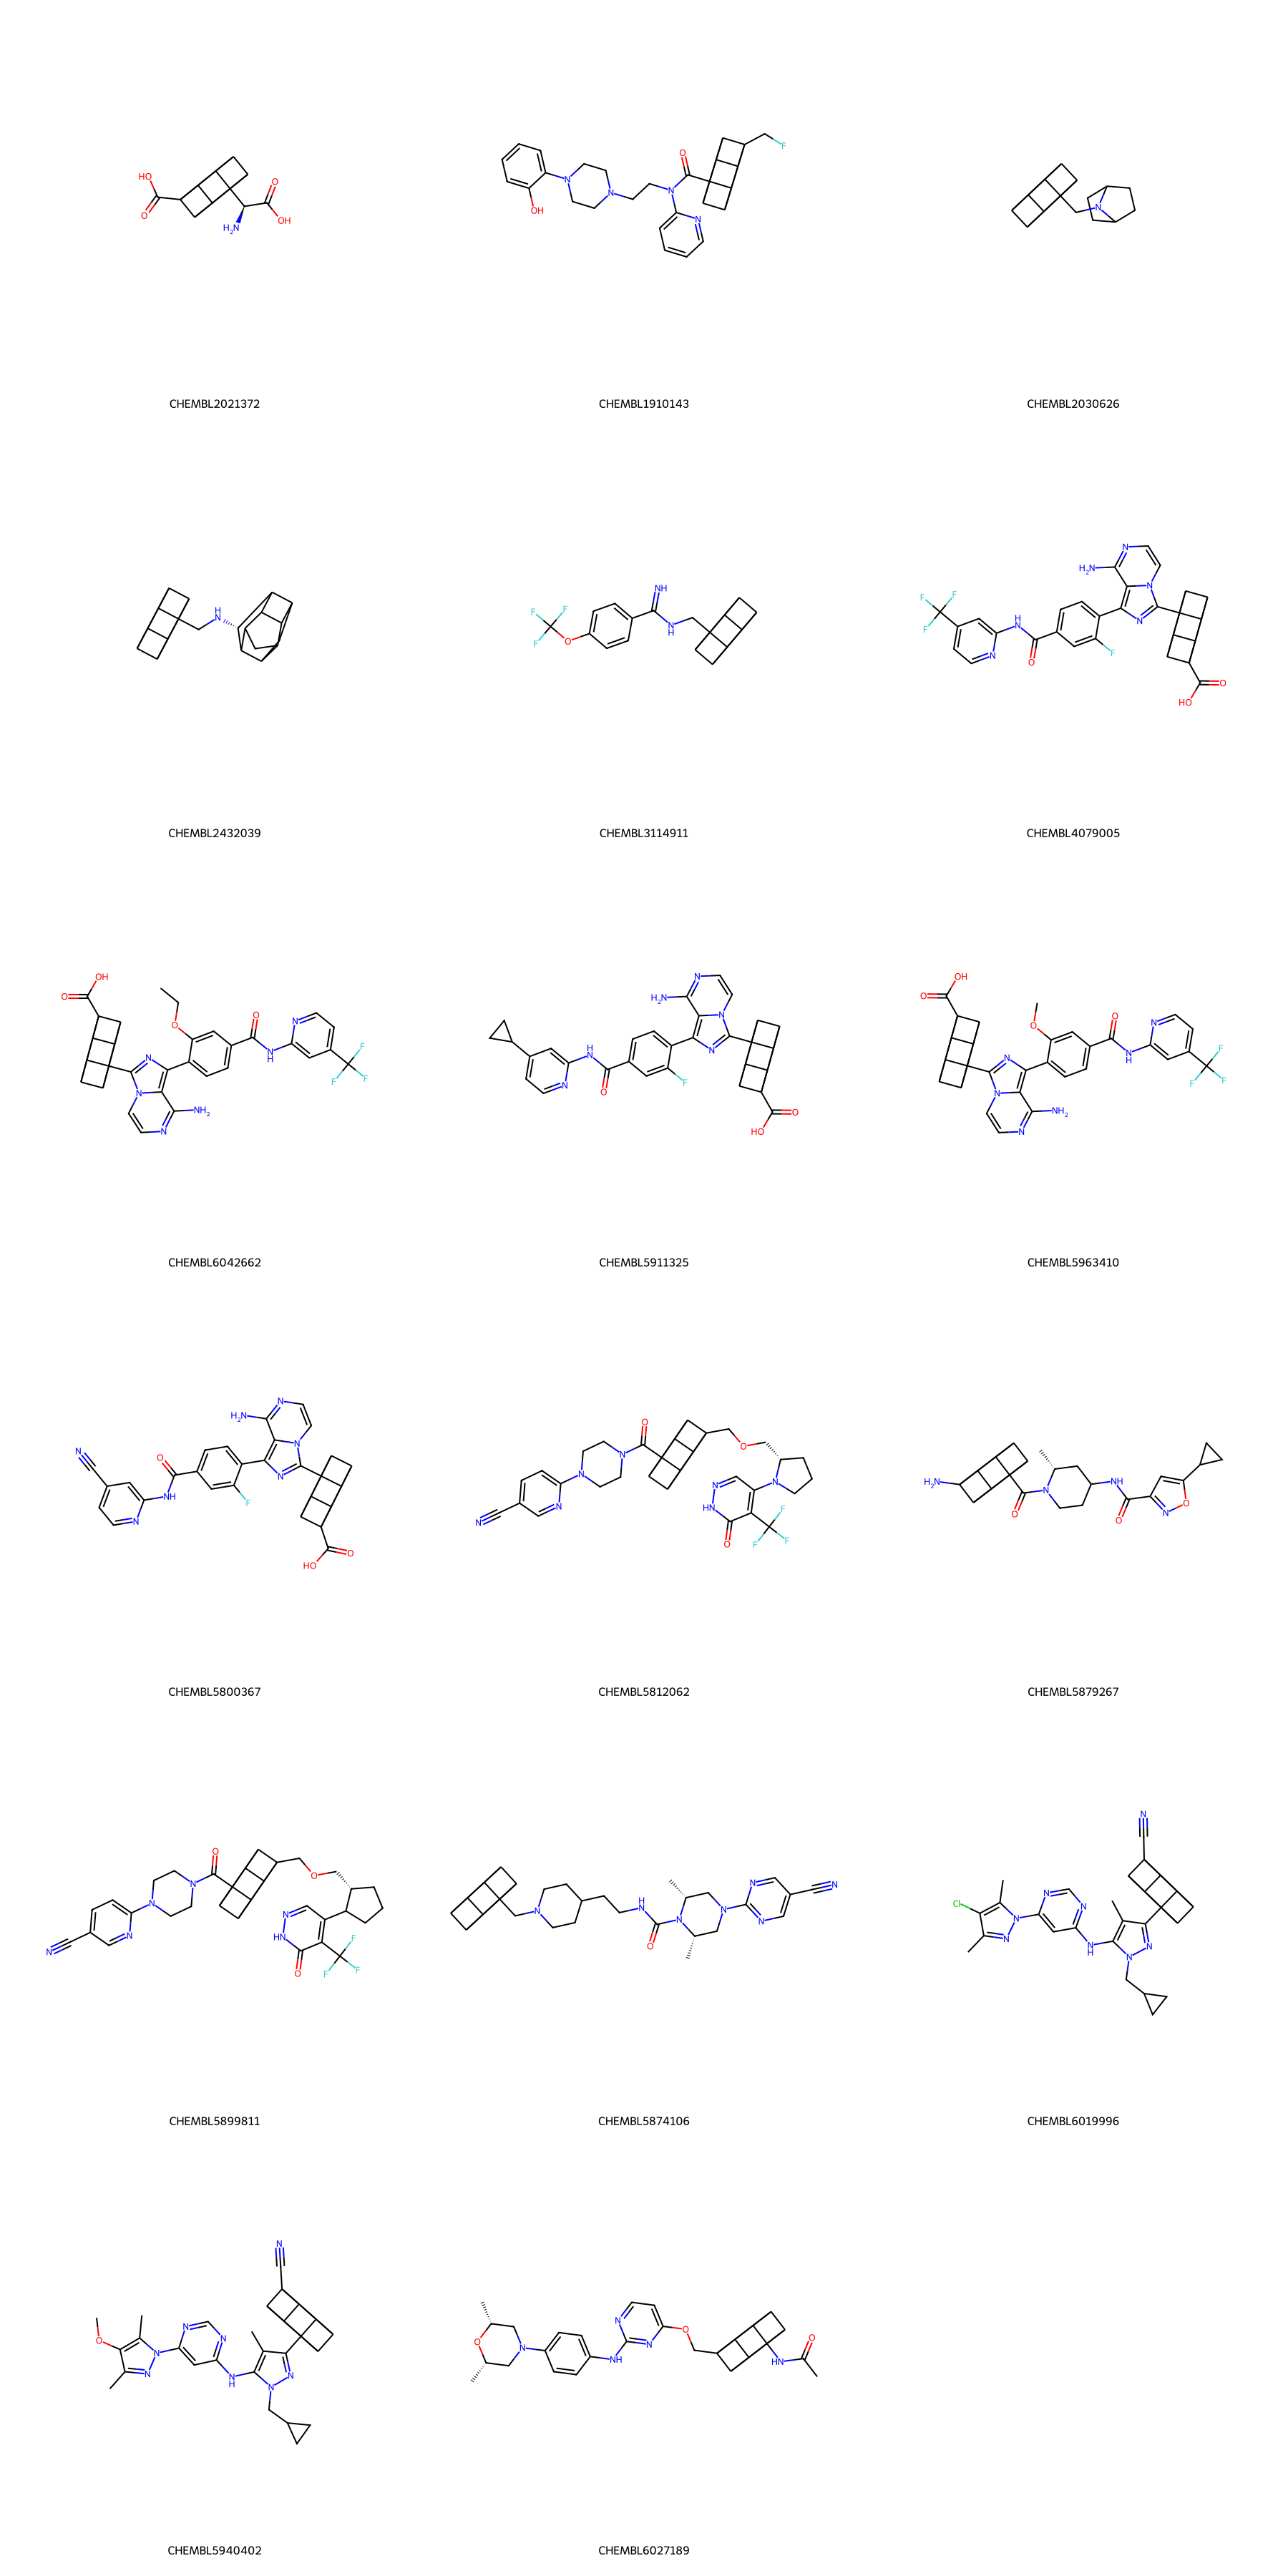

In [17]:
#visualise the matched molecules
print(f"Number of molecules matching the substructure {sub1}: {matched_mols.shape[0]}")
mols = [Chem.MolFromSmiles(smiles) for smiles in matched_mols['SMILES']]
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(600,600), legends=[f"{chembl_id}" for chembl_id in matched_mols['chembl_id']])
img